<a href="https://colab.research.google.com/github/Emmyeka1/Coursera_Capstone/blob/main/The_Battle_of_Neighborhoods_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Python Libraries imported.')

Python Libraries imported.


# **1. Download and Explore Dataset.**

## New York City has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

### Then, we will scrape data from wikipedia into a dataframe using BeautifulSoup package. The data sources are https://en.wikipedia.org/wiki/New_York_City and https://en.wikipedia.org/wiki/Demographics_of_New_York_City.

In [2]:
response_obj = requests.get('https://en.wikipedia.org/wiki/New_York_City').text
soup = BeautifulSoup(response_obj,'lxml')
Neighborhoods_NYC_Table = soup.find('table', {'class':'wikitable sortable'})

In [3]:
rows = Neighborhoods_NYC_Table.select("tbody > tr")[3:8]

boroughs = []
for row in rows:
    borough = {}
    tds = row.select('td')
    borough["borough"] = tds[0].text.strip()
    borough["county"] = tds[1].text.strip()
    borough["population"] = float(tds[2].text.strip().replace(",",""))
    borough["gdp_billions"] = float(tds[3].text.strip().replace(",",""))
    borough["gdp_per_capita"] = float(tds[4].text.strip().replace(",",""))
    borough["land_sqm"] = float(tds[5].text.strip().replace(",",""))
    borough["land_sqkm"] = float(tds[6].text.strip().replace(",",""))
    borough["persons_sqm"] = float(tds[7].text.strip().replace(",",""))
    borough["persons_sqkm"] = float(tds[8].text.strip().replace(",",""))
    
    boroughs.append(borough)

print(boroughs)

[{'borough': 'The Bronx', 'county': 'Bronx', 'population': 1418207.0, 'gdp_billions': 42.695, 'gdp_per_capita': 30100.0, 'land_sqm': 42.1, 'land_sqkm': 109.04, 'persons_sqm': 33867.0, 'persons_sqkm': 13006.0}, {'borough': 'Brooklyn', 'county': 'Kings', 'population': 2559903.0, 'gdp_billions': 91.559, 'gdp_per_capita': 35800.0, 'land_sqm': 70.82, 'land_sqkm': 183.42, 'persons_sqm': 36147.0, 'persons_sqkm': 13957.0}, {'borough': 'Manhattan', 'county': 'New York', 'population': 1628706.0, 'gdp_billions': 600.244, 'gdp_per_capita': 368500.0, 'land_sqm': 22.83, 'land_sqkm': 59.13, 'persons_sqm': 71341.0, 'persons_sqkm': 27544.0}, {'borough': 'Queens', 'county': 'Queens', 'population': 2253858.0, 'gdp_billions': 93.31, 'gdp_per_capita': 41400.0, 'land_sqm': 108.53, 'land_sqkm': 281.09, 'persons_sqm': 20767.0, 'persons_sqkm': 8018.0}, {'borough': 'Staten Island', 'county': 'Richmond', 'population': 476143.0, 'gdp_billions': 14.514, 'gdp_per_capita': 30500.0, 'land_sqm': 58.37, 'land_sqkm': 15

In [4]:
df = pd.DataFrame(boroughs, columns=["borough","county", "population", "gdp_per_capita", "persons_sqkm"]) 
df.head()

,borough,county,population,gdp_per_capita,persons_sqkm
0,The Bronx,Bronx,1418207.0,30100.0,13006.0
1,Brooklyn,Kings,2559903.0,35800.0,13957.0
2,Manhattan,New York,1628706.0,368500.0,27544.0
3,Queens,Queens,2253858.0,41400.0,8018.0
4,Staten Island,Richmond,476143.0,30500.0,3150.0


## Use BeautifulSoup package to get the cultural diversity of boroughs in NYC.

In [5]:
response_obj = requests.get('https://en.wikipedia.org/wiki/Demographics_of_New_York_City').text
soup = BeautifulSoup(response_obj,'lxml')
Population_Census_Table = soup.select_one('.wikitable:nth-of-type(5)')

In [6]:
rows = Population_Census_Table.select("tbody > tr")[3:8]

jurisdictions = []

for row in rows:
    jurisdiction = {}
    tds = row.select('td')
    jurisdiction["jurisdiction"] = tds[0].text.strip()
    jurisdiction["population_census"] = tds[1].text.strip()
    jurisdiction["%_white"] = float(tds[2].text.strip().replace(",",""))
    jurisdiction["%_black_or_african_amercian"] = float(tds[3].text.strip().replace(",",""))
    jurisdiction["%_Asian"] = float(tds[4].text.strip().replace(",",""))
    jurisdiction["%_other"] = float(tds[5].text.strip().replace(",",""))
    jurisdiction["%_mixed_race"] = float(tds[6].text.strip().replace(",",""))
    jurisdiction["%_hispanic_latino_of_other_race"] = float(tds[7].text.strip().replace(",",""))
    jurisdiction["%_catholic"] = float(tds[10].text.strip().replace(",",""))
    jurisdiction["%_jewish"] = float(tds[12].text.strip().replace(",",""))
    jurisdictions.append(jurisdiction)

print(jurisdictions)

AttributeError: ignored

In [ ]:
df = pd.DataFrame(jurisdictions, columns=["jurisdiction","%_white", "%_black_or_african_amercian", "%_Asian", "%_other", "%_mixed_race", "%_hispanic_latino_of_other_race"])
df.head()

## Use geopy library to get longitude and latitude coordinates.

In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [6]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'M22NS04LGY5MK1VP0Z4VVR3ESIYQUDCOK3ENDHPS10FFVTOP'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='04C4XWWNWI0FXJ4JRO034FUTF2PXWEHKRLVORUJ4NJIADYEY' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20201126' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    results['response'] 
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [7]:
def get_venue_details(venue_id):


    CLIENT_ID = 'M22NS04LGY5MK1VP0Z4VVR3ESIYQUDCOK3ENDHPS10FFVTOP'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='04C4XWWNWI0FXJ4JRO034FUTF2PXWEHKRLVORUJ4NJIADYEY' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20201126' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [8]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [9]:
# get new york data
new_york_data=get_new_york_data()

In [10]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
new_york_data.shape

(306, 4)

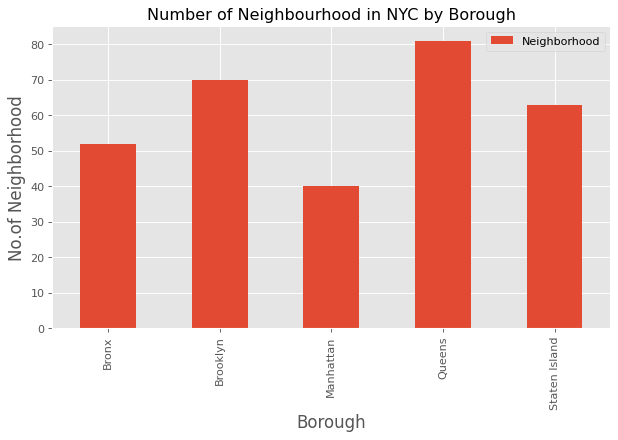

In [12]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

# prepare neighborhood list that contains African restaurant


In [13]:
# prepare neighborhood list that contains African restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
african_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    african_resturants=venues[venues['Category']=='African Restaurant']   
    print('(',count,'/',len(new_york_data),')','African Restaurants in '+Neighborhood+', '+Borough+':'+str(len(african_resturants)))
    for resturant_detail in african_resturants.values.tolist():
        id, name , category=resturant_detail
        african_rest_ny = african_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

KeyError: ignored

In [ ]:
african_rest_ny.head()

In [ ]:
african_rest_ny.shape

In [ ]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of African Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of African Restaurant', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It is noted that Bronx and Manhattan has the highest number of African Restaurants. We will be focusing on Central Harlem, Manhattan because it has 4 African Restaurants; the most for a neighbourhood in New York City.

In [ ]:
african_rest_ny[african_rest_ny['Neighborhood']=='Central Harlem']

In [ ]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of African Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Africanan Restaurants', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

As earlier mentioned, Central Harlem, Manhattan has the most African Restaurants in New York City with a total count of 4.

In [ ]:
# prepare neighborhood list that contains African Restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
african_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in african_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains African Restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
african_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in african_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID) # We will assign 0 value for these restaurants as they may have been recently opened or their details does not exist in the FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(african_rest_ny),')','processed')
    african_rest_stats_ny = african_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [ ]:
african_rest_stats_ny.head()

In [ ]:
african_rest_stats_ny.shape

In [ ]:
african_rest_stats_ny.to_csv('african_rest_stats_ny.csv', index=False)

In [ ]:
african_rest_stats_ny_csv=pd.read_csv('african_rest_stats_ny.csv')

In [ ]:
african_rest_stats_ny_csv.shape

In [ ]:
african_rest_stats_ny_csv.head()

In [ ]:
african_rest_stats_ny.info()

Use pandas.Series.astype to conver Likes, Tips and rating object dtypes to float dtypes for ease of data analysis.

In [ ]:
african_rest_stats_ny['Likes']=african_rest_stats_ny.Likes.astype(float)

In [ ]:
african_rest_stats_ny['Tips']=african_rest_stats_ny.Tips.astype(float)

In [ ]:
african_rest_stats_ny['Rating']=african_rest_stats_ny.Rating.astype(float)

In [ ]:
african_rest_stats_ny.info()

In [ ]:
# African Restaurant with maximum Likes
african_rest_stats_ny.iloc[african_rest_stats_ny['Likes'].idxmax()]

In [ ]:
# African Restaurant with maximum Tips
african_rest_stats_ny.iloc[african_rest_stats_ny['Tips'].idxmax()]

In [ ]:
# African Restaurant with maximum Rating
african_rest_stats_ny.iloc[african_rest_stats_ny['Rating'].idxmax()]

In [ ]:
ny_neighborhood_stats=african_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [ ]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

In [ ]:
ny_borough_stats=african_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [ ]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

In [ ]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of African Restaurants in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
african_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We observe that the Bronx has the highest average rating for African Restaurants in NYC Boroughs.

Next, we will filter all neighborhoods >= 7, and create a map to visualize them.

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [ ]:
ny_neighborhood_stats

Then, we will merge data and get the longitude and latitude coordinates to create a map.

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [ ]:
# Create a table to view the dataframe
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

In [ ]:
# Create a folium map to display the merged dataframe. 
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [ ]:
# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# Loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # Define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

Neighbourhood in New York City with the highest average rating for African Restaurants.

In [ ]:
# Add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# Add incidents to map
ny_map.add_child(incidents)